<a href="https://colab.research.google.com/github/AnnaM-C/computational-intelligence/blob/main/Gradient_Descent_with_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ref:https://medium.com/@nagam808surya/cifar-10-image-classification-using-pytorch-90332041ba1f
#CIFAR-10 dataset from https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf


In [ ]:
#check how many GPUs you have on the device
gpus = tf.config.list_physical_devices('GPU')
print("List of physical GPUs:", gpus)
print("Num GPUs Available: ", len(gpus))
if gpus:
# Use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

List of physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [ ]:
#normalise pixel values (range:-1 to 1, mean:0.5, s.d:0.5)
transform=transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

classes=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 13024763.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#feed images in batches
batch_size=5
trainloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader=torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

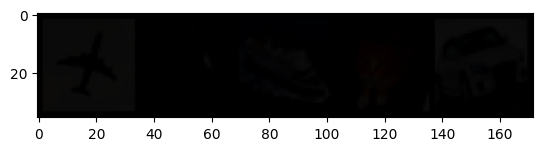

planefrogshipcatcar


In [ ]:
#visualise images from the trainloader
def imshow(img):
    img=img/2_0.5 #unnormalise
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

#random image
dataiter=iter(trainloader)
images,labels=next(dataiter)

#show image
imshow(torchvision.utils.make_grid(images))

#print labels
print(''.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
#build the network (architecture)
#relu is used because it is fast

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,10,5) #conv layer's output dimension formula (W-F+2P/S+1) W-input image size, F-kernal size, P-padding, S-Stride
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(10,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

net=Net()


In [ ]:
#choose an optimiser algorithm
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimiser=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [ ]:
#epochs
lossTracker=[]

for epoch in range(2): #loop through the dataset multiple times to update the weights
    running_loss=0.0
    running_loss_track=0.0
    for i,data in enumerate(trainloader,0):
        #get inputs; data is a list of [inputs,labels]
        inputs,label=data

        #zero the parameter gradients
        optimiser.zero_grad()

        #forward+backward+optimise
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimiser.step()

        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: #print every 2000 mini-batches
            print('[%d,%5d] loss: %.3f'% (epoch+1,i+1,running_loss/2000))
            running_loss_track+=running_loss/2000
            running_loss=0.0

    #calculate average losses
    running_loss_track=running_loss_track/5
    print("Average loss->",running_loss_track)
    lossTracker.append(running_loss_track)

print('Finished Training')

[1, 2000] loss: 1.612
[1, 4000] loss: 1.612
[1, 6000] loss: 1.611
[1, 8000] loss: 1.611
[1,10000] loss: 1.611
Average loss-> 1.61156706597805
[2, 2000] loss: 1.611
[2, 4000] loss: 1.610
[2, 6000] loss: 1.611
[2, 8000] loss: 1.611
[2,10000] loss: 1.610
Average loss-> 1.6105745094776154
Finished Training


In [ ]:
PATH='./cifar_net.pth'
torch.save(net.state_dict(),PATH)

In [ ]:
net=Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

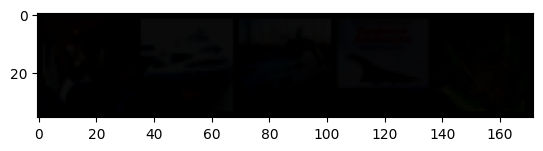

GroundTruth:    cat  ship  ship plane  frog


In [ ]:
#random image
dataiter=iter(testloader)
images,labels=next(dataiter)

#show image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s'%classes[labels[j]] for j in range(5)))

In [ ]:
outputs=net(images)

In [ ]:
_,predicted=torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s'%classes[predicted[j]]
                             for j in range(5)))

Predicted:    cat   cat   cat   cat   cat


In [ ]:
#overall accuracy
correct=0
total=0
#since we're not training, we dont need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images,labels=data
        #calculate outputs by running images through the network
        outputs=net(images)
        #the class with the highest energy is what we choose as prediction
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct/total))

Accuracy of the network on the 10000 test images: 10 %


In [ ]:
#accuracy for each class
#prepare to count predictions for each class
correct_pred={classname: 0 for classname in classes}
total_pred={classname: 0 for classname in classes}

#no gradients needed
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predictions=torch.max(outputs,1)
        #collect the correct predictions for each class
        for label,prediction in zip(labels,predictions):
            if label==prediction:
                correct_pred[classes[label]]+=1
            total_pred[classes[label]]+=1

#print accuracy for each class
for classname,correct_count in correct_pred.items():
    accuracy=100*float(correct_count)/total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,accuracy))


Accuracy for class plane is: 0.4 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 99.1 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 0.0 %
Accuracy for class frog  is: 0.5 %
Accuracy for class horse is: 0.0 %
Accuracy for class ship  is: 0.4 %
Accuracy for class truck is: 0.0 %


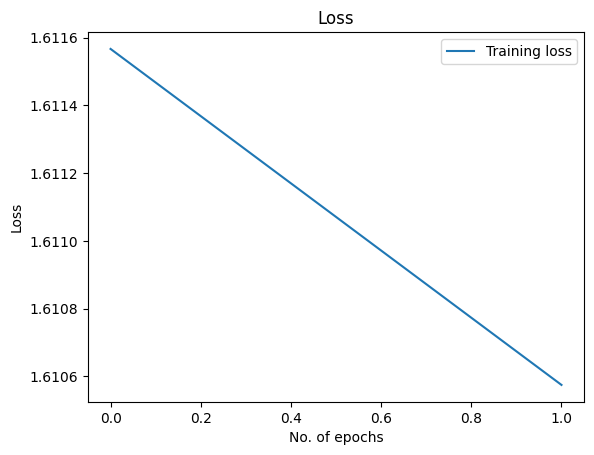

In [ ]:
plt.plot(np.arange(0,2), lossTracker, label='Training loss')
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()